<a href="https://colab.research.google.com/github/gabrielfernandorey/ITBA-NLP/blob/main/NLP_02_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico NLP - Detección de Tópicos y clasificación
- ITBA 2024
- Alumno: Gabriel Rey
---

### NLP_02_model

Esta notebook se utiliza para:
- armar el modelo de estimación de tópicos
- validar resultados obtenidos
- guardar datos en los indices de opensearch

Esta y las consecuentes notebooks son el desarrollo de base de procesos y funciones para la web app provista.

### MODELO

In [45]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pickle
from datetime import datetime, date, timedelta
from dateutil.parser import parse
from dotenv import load_dotenv
from IPython.display import Image, display

from NLP_tools import *


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

from tqdm import tqdm

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

In [3]:
from opensearch_data_model import Topic, TopicKeyword, News, os_client, TOPIC_INDEX_NAME, NEWS_INDEX_NAME
from opensearch_io import init_opensearch, get_news, get_entities_news, get_title_news, update_news, get_pos_id
from opensearchpy import helpers

from openai import OpenAI

### Path

In [4]:
load_dotenv()
PATH_REMOTO='/content/ITBA-NLP/data/'
PATH=os.environ.get('PATH_LOCAL', PATH_REMOTO)
PATH

'C:/Users/gabri/OneDrive/Machine Learning/Github/ITBA-NLP/data/'

In [5]:
if PATH == os.environ.get('PATH_LOCAL'):
    if os.environ.get('OPENAI_API_KEY'):
        client = OpenAI(api_key= os.environ.get('OPENAI_API_KEY'))
    else:
        client = None
    print(client)

### Inicializamos la base vectorial

In [6]:
init_opensearch()

El índice Topic ya existe. Saltando inicialización de base de datos.
El índice News ya existe. Saltando inicialización de base de datos.


### Data de noticias original

In [7]:
# Cargar archivo previamente preprocesado en NLP_01_data 
choice = "20240716"   
df_parquet = pd.read_parquet(PATH+choice+".parquet").reset_index()
data = list(df_parquet['text'])
id_data = list(df_parquet['asset_id'])
title_data = list(df_parquet['title'])

In [8]:
# Cargar vocabulario previamente procesado
with open(PATH+f'preproc_notebook/vocabulary_{choice}.json', 'r') as json_file:
    vocab = json.load(json_file)
len(vocab)

6233

### Preprocesar las noticias
Se realiza un preprocesamiento mínimo del texto, pero no se le quita el sentido semántico para que mediante SentenceTransformer se puedan capturar embeddings de mejor calidad.

In [9]:
# Stopwords
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)
SPANISH_STOPWORDS_SPECIAL = list(pd.read_csv(PATH+'spanish_stop_words_spec.csv' )['stopwords'].values)

In [10]:
clean_data = Cleaning_text()

proc_data = []
for data_in in tqdm(data):
    aux = clean_data.unicode(data_in)
    aux = clean_data.urls(aux)
    aux = clean_data.simbols(aux)
    aux = clean_data.escape_sequence(aux)
    aux = " ".join([ word for word in aux.split() if word.lower() not in SPANISH_STOPWORDS_SPECIAL])
    proc_data.append(aux)


100%|██████████| 1000/1000 [00:00<00:00, 1758.02it/s]


### Modelo

In [11]:
tfidf_vectorizer = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 2),
        vocabulary=vocab,
        # max_features=100_000
)
tfidf_vectorizer.fit(proc_data)

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 2),
                vocabulary=['Jakari Shaw', 'Observatorio Turístico',
                            'utilización', 'tragedia', 'Ignacio «Nacho» Torres',
                            'acusado número', 'incidentes', 'Adolfo Alsina',
                            'teléfono celular', 'Las Zetas',
                            'peregrinación acuática', 'políticas actuales',
                            'últimos datos', 'pisos', 'residencia fiscal',
                            'carros', 'Sol de Mayo', 'Sierra Chica', 'lingotes',
                            'Puerto Escobar', 'Dirección', 'Audi',
                            'Lorena Paola Medina', 'Tiago Nunes',
                            'Cadena 3 Rosario', 'cerro Champaquí', 'Nobel',
                            'Scott Panchik', 'baja velocidad', 'moneda oficial', ...])

Capas del modelo BERTopic

In [12]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 4 - Tokenize topics
vectorizer_model = tfidf_vectorizer
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()
# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
# representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,              # Step 1 - Extract embeddings
  umap_model=umap_model,                        # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,                  # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,            # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                    # Step 5 - Extract topic words
  # representation_model=representation_model,  # Step 6 - (Optional) Fine-tune topic represenations
  # language='multilingual',                    # This is not used if embedding_model is used.
  verbose=True,
  # calculate_probabilities=True
)

### Datos de Entrenamiento a recuperar

In [13]:
# Cargar modelo entrenado o saltar celda y entrenar
#topic_model = BERTopic.load(PATH+f"modelos_notebook/bertopic_model_{choice}")
#topics = np.load(PATH+f"modelos_notebook/topics_{choice}.npy")
#probs = np.load(PATH+f"modelos_notebook/probs_{choice}.npy")

# Cargar los embeddings
#docs_embedding = np.load(PATH+f"modelos_notebook/docs_embeddings_{choice}.npy")

### Entrenamiento

In [14]:
# Entrenamiento
topics, probs = topic_model.fit_transform(proc_data)

2024-08-29 13:51:17,802 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-08-29 13:52:51,986 - BERTopic - Embedding - Completed ✓
2024-08-29 13:52:51,987 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-29 13:53:02,461 - BERTopic - Dimensionality - Completed ✓
2024-08-29 13:53:02,462 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-29 13:53:02,500 - BERTopic - Cluster - Completed ✓
2024-08-29 13:53:02,508 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-29 13:53:03,107 - BERTopic - Representation - Completed ✓


In [15]:
# Obtenemos embeddings de todos los documentos
docs_embedding = topic_model.embedding_model.embed(data)

### Datos de entrenamiento a guardar

In [17]:
# Grabar modelo
topic_model.save(PATH+f"modelos_notebook/bertopic_model_last")
#np.save(PATH+f"modelos_notebook/topics_{choice}.npy", topics)
#np.save(PATH+f"modelos_notebook/probs_{choice}.npy", probs)

# Guardar los embeddings en un archivo de NumPy
np.save(PATH+f"modelos_notebook/docs_embeddings_last.npy", docs_embedding)

2024-08-29 13:57:51,689 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


## Grabar solo resultados del primer modelo en Topic y News
*** El segundo modelo corre en NLP_03_merged, para luego fusionar. ***

### Actualizar datos en news 

In [18]:
# Marcar registros de noticias como procesados y grabar sus embeddings, topicos, probs 
update_news( id_data, docs_embedding, topics, probs )

True

### Grabar todos los registros en Topic y la actualizacion en news

In [19]:
# Grabar todos los topicos en la base
date_choice = choice[:4]+"-"+choice[4:6]+"-"+choice[6:8]

for topic_id in topic_model.get_topics().keys():
    if topic_id > -1:

        topic_keywords_top  = top_keywords(topic_id, topic_model, PATH)
        topic_entities_top  = top_entities(topic_id, topic_model, df_parquet)
        topic_documents_title, threshold  = topic_documents(topic_id, topic_model, df_parquet)
        id_best_doc, title_best_doc, best_doc = best_document(topic_id, topic_model, docs_embedding, id_data, title_data, data)
        

        topic_doc = Topic(
            index = topic_id,
            name =  get_topic_name(''.join(topic_documents_title), topic_id, topic_model, client),
            vector = list(topic_model.topic_embeddings_[topic_id + 1 ]),
            similarity_threshold = threshold,
            created_at = datetime.now(),
            from_date = parse(date_choice),
            to_date = datetime.strptime(date_choice, '%Y-%m-%d') + timedelta(days=1),
            keywords = topic_keywords_top,
            entities = topic_entities_top,
            id_best_doc = id_best_doc,
            title_best_doc = title_best_doc,
            best_doc = best_doc,
        )

        topic_doc.save()



## Resultados y operaciones con el modelo

In [20]:
print(f"Cantidad de tópicos {len(set(topic_model.topics_))} (incluye topico -1)")

Cantidad de tópicos 19 (incluye topico -1)


In [21]:
# Obtener documentos de cada tópico
topic_freq = topic_model.get_topic_freq()

# Imprimir el número de tópicos encontrados (incluyendo el tópico -1)
num_topics = len(topic_freq)
print(f"Número de tópicos encontrados: {num_topics} (incluye el topico -1)")

# Imprimir la cant de documentos de cada tópico
print(topic_freq.to_string(index=False))

Número de tópicos encontrados: 19 (incluye el topico -1)
 Topic  Count
    -1    237
     0    146
     1     96
     2     91
     3     64
     4     45
     5     43
     6     37
     7     36
     8     34
     9     28
    10     26
    11     24
    12     21
    13     17
    14     16
    15     14
    16     14
    17     11


### Recuperar todos los topicos y sus etiquetas generadas por el modelo

In [22]:
topic_labels = topic_model.generate_topic_labels()
topic_labels

['-1_años_selección_final',
 '0_víctima_policía_robo',
 '1_ciudad_agua_espacio',
 '2_dólar_bitcoin_dólares',
 '3_gobierno_ministro_reunión',
 '4_selección_selección argentina_títulos',
 '5_url ordinal_visible seccion_dato confiable',
 '6_temperaturas_invierno_temperatura',
 '7_dni terminados_julio_embarazo',
 '8_inversiones_gobernador_planta',
 '9_refuerzos_error_jugadores',
 '10_sociedades_sociedades anónimas_asociaciones civiles',
 '11_árbitro asistente_playoff_fecha',
 '12_ela_em_separación',
 '13_convención_mitin_asesinato',
 '14_banda_lomitos_pesca',
 '15_inteligencia_agencia_agencias',
 '16_bomberos_incendio_fuego',
 '17_francés_jugador_club']

### Buscar topicos ingresando un texto

In [23]:
topic_res = topic_model.find_topics("cambio climatico")
print(topic_res)
topic_labels[topic_res[0][np.argmax(topic_res[1])]+1]

([6, 2, 8, 1, 16], [0.5449766, 0.31518775, 0.25997964, 0.2517021, 0.23166545])


'6_temperaturas_invierno_temperatura'

## Elegir un topico para pruebas

In [24]:
# Obtener los n documentos de un tópico
topic_id = np.random.randint(len(set(topic_model.topics_))-1) # Obtener un topico al azar
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

Topico N°: 5 --> 5_url ordinal_visible seccion_dato confiable


### Buscar los titulos de los primeros n documentos de un topico

In [25]:
n_docs = 5  # N documentos a recuperar
topic_docs_idx = [i for i, (doc, topic) in enumerate(zip(list(df_parquet['title']), topic_model.topics_)) if topic == topic_id]
n_docs = n_docs if n_docs <= len(topic_docs_idx) else len(topic_docs_idx)

print(f"{n_docs} de {len(topic_docs_idx)} titulos de noticias encontrados en el tópico {topic_id:}")
for idx in topic_docs_idx[:n_docs]:
    print("- ",df_parquet.iloc[idx]['title'])

5 de 43 titulos de noticias encontrados en el tópico 5
-  Farmacia de turno
-  Museo GüemesLa Cámara de Diputados de Buenos Aires reconoció a Güemes como héroe nacional
-  La princesa Leonor visita Galicia, su casa el próximo año: el abandono exprés de Juan Carlos I y un emotivo reencuentro
-  El cronograma de los mercados itinerantes de Moreno para los próximos días
-  Agenda


#### Busqueda de documentos por topico, ordenados por mayor probabilidad

In [26]:
docs_per_topics = [i for i, x in enumerate(topic_model.topics_) if x == topic_id]
score_docs = topic_model.probabilities_[docs_per_topics]

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

reg_data = []
for i, doc in enumerate(docs_per_topics):
    reg_data.append([df_parquet.iloc[doc].asset_id, df_parquet.iloc[doc].title, round(score_docs[i],4)])

df_query = pd.DataFrame(reg_data, columns=['ID','titulo','score'])
print(len(df_query), "docs encontrados")
df_query.sort_values('score', ascending=False).style.set_properties(subset=['titulo'], **{'text-align': 'left'})

Topico N°: 5 --> 5_url ordinal_visible seccion_dato confiable
43 docs encontrados


,ID,titulo,score
21,114829049,Chubut recibió 15 ambulancias de la Provincia de Buenos Aires,1.000000
14,114878111,Las apps de movilidad se amplían en Mendoza y un importante jugador llega a San Rafael,1.000000
41,114849918,Entregan 149 escrituras a familias lujanenses,1.000000
40,114818914,Talleres para diferentes etapas del embarazo y la familia,1.000000
5,114817993,"Xuxa pede o despejo de inquilino por dívida de R$ 14 mil, diz colunista",1.000000
31,114835295,"Seguí con ""LA GACETA Central"", con toda la información de Tucumán",1.000000
29,114851890,TAPA Martes 16 de Julio de 2024,1.000000
27,114870623,Biss participó del acto por el Día del Servicio Penitenciario Federal,1.000000
25,114847456,Mauro Cezar: Ramon Díaz talvez seja uma versão argentina do Luxemburgo,1.000000
22,114850991,Feria de emprendedores este viernes en el Paseo Evita,1.000000


### Criterio de corte (umbral)
El criterio de corte utilizado para filtrar las noticias que pertenecen a un topico es la "media"

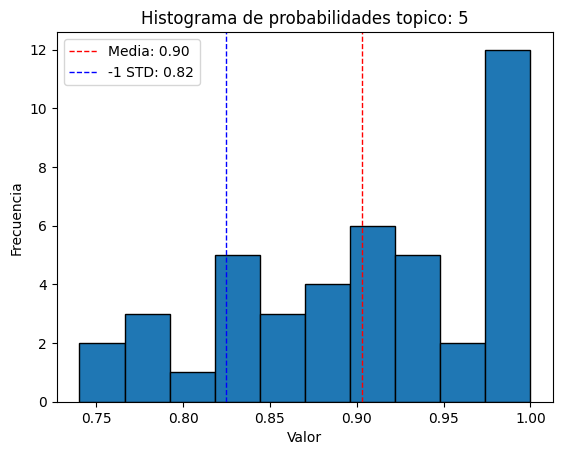

In [27]:
# Calcular la media, el desvío estándar

mean = np.mean([fila[2] for fila in reg_data])
std_dev = np.std([fila[2] for fila in reg_data])

# Crear el histograma
plt.hist([fila[2] for fila in reg_data], bins=10, edgecolor='black')

# Añadir líneas para la media, la moda y el desvío estándar
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Media: {mean:.2f}')
plt.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=1, label=f'-1 STD: {mean - std_dev:.2f}')


# Añadir títulos y etiquetas
plt.title(f'Histograma de probabilidades topico: {topic_id}')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

In [28]:
# Definir la función de estilo
def color_rows(row, label, value):
    if row[label] >= value:
        return ['color: cyan'] * len(row)
    else:
        return [''] * len(row)

# Calcular la media
threshold = df_query.score.mean()

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
print(f"Umbral de corte {threshold}")

df_query.sort_values('score', ascending=False, inplace=True)
df_query.style.apply(lambda row: color_rows(row, 'score', threshold), axis=1).set_properties(subset=['titulo'], **{'text-align': 'left'})

Topico N°: 5 --> 5_url ordinal_visible seccion_dato confiable
Umbral de corte 0.9027744186046512


,ID,titulo,score
21,114829049,Chubut recibió 15 ambulancias de la Provincia de Buenos Aires,1.000000
14,114878111,Las apps de movilidad se amplían en Mendoza y un importante jugador llega a San Rafael,1.000000
41,114849918,Entregan 149 escrituras a familias lujanenses,1.000000
40,114818914,Talleres para diferentes etapas del embarazo y la familia,1.000000
5,114817993,"Xuxa pede o despejo de inquilino por dívida de R$ 14 mil, diz colunista",1.000000
31,114835295,"Seguí con ""LA GACETA Central"", con toda la información de Tucumán",1.000000
29,114851890,TAPA Martes 16 de Julio de 2024,1.000000
27,114870623,Biss participó del acto por el Día del Servicio Penitenciario Federal,1.000000
25,114847456,Mauro Cezar: Ramon Díaz talvez seja uma versão argentina do Luxemburgo,1.000000
22,114850991,Feria de emprendedores este viernes en el Paseo Evita,1.000000


#### Documentos mas representativos de un topico

- [1]  Desde el metodo del modelo

In [29]:
docs_representative = topic_model.get_representative_docs(topic=topic_id)
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
docs_representative

Topico N°: 5 --> 5_url ordinal_visible seccion_dato confiable


['EN VIVO 3 Argentina Ahora país Guillermo López 3 Rosario Siempre Juntos Rosario Alberto Lotuf Heat Una que sabemos todos Música La Popu Los Populares Colorete Gianola Cosquín Rock Cosquín Rock Muy pronto La Mesa de Café 3x1 4 Por Sergio Suppo Un Mundo de Historias Siempre Juntos Actualidad La quinta pata del gato Por Adrián Simioni Siempre Juntos Rosario El dato confiable Por Federico Albarenque Radioinforme 3 Radioinforme 3 Siempre Juntos Rosario Siempre Juntos La Mesa de Café Otra mirada Por Fernando Genesir Radioinforme 3 Rosario Radioinforme 3 Rosario Radioinforme 3 Radioinforme 3 Radioinforme 3 Radioinforme 3 Radioinforme 3 Radioinforme 3 Radioinforme 3 Radioinforme 3 Radioinforme 3 Cuadro de situación Por Sergio Berensztein Radioinforme 3 Radioinforme 3 Radioinforme 3 Radioinforme 3 Radioinforme 3 Rosario Radioinforme 3 Rosario Turno Noche al Cuadrado al regreso al regreso la Abrapalabra la la la Copa América 2024 En familia aquí y allá Ahora país La de Pablo Sirvén Ahora país 

- [2] Por similitud coseno del topico a los tres documento mas cercanos

In [30]:
# Obtenemos la matriz de similitud coseno entre topicos y documentos
sim_matrix = cosine_similarity(topic_model.topic_embeddings_, docs_embedding)
sim_matrix.shape

(19, 1000)

In [31]:
# Similitud coseno entre el topico y los documentos del topico elegido
s_coseno = []
for i in docs_per_topics:
    s_coseno.append(cosine_similarity([topic_model.topic_embeddings_[topic_id + 1]], [docs_embedding[i]])[0][0])

# Indices
idx_coseno_sort = np.argsort(s_coseno)[::-1]

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

for idx in idx_coseno_sort[:3]:
    print(idx, df_parquet.iloc[docs_per_topics[idx]].title)


Topico N°: 5 --> 5_url ordinal_visible seccion_dato confiable
28 Se realizará un curso de chacinados y embutidos caseros en Trelew
27 Biss participó del acto por el Día del Servicio Penitenciario Federal
21 Chubut recibió 15 ambulancias de la Provincia de Buenos Aires


- [3] Primer documento mas cercano al embedding del topico

In [32]:
# Documento de maxima similitud con el topico

simil_docs_topic = sim_matrix[topic_id+ 1].argmax()
print(f"Noticia de maxima similitud con el topico: {topic_id}")
print(f"Doc ID: {df_parquet.index[simil_docs_topic]}")
print(f"Titulo: {df_parquet.iloc[simil_docs_topic].title}")
best_doc = data[simil_docs_topic]

Noticia de maxima similitud con el topico: 5
Doc ID: 748
Titulo: Se realizará un curso de chacinados y embutidos caseros en Trelew


#### Keywords de un topico (modelo)

In [33]:
# Obtener las palabras clave para un topico dado
topic_keywords = topic_model.get_topic(topic_id)
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
print(topic_keywords)

Topico N°: 5 --> 5_url ordinal_visible seccion_dato confiable
[('url ordinal', 0.05215937754684874), ('visible seccion', 0.05215937754684874), ('dato confiable', 0.03307001885180649), ('quinta pata', 0.0304257475889183), ('nombre', 0.029350674355965355), ('autopista', 0.028009524515433714), ('feria', 0.027269849448666342), ('detalle', 0.026344920373670592), ('mail', 0.025164916990443868), ('nueva directora', 0.024895714804563332)]


#### Keywords de un topico (otra forma de obtenerlos)

In [34]:
keywords = topic_model.topic_representations_[topic_id]
topic_keywords = [TopicKeyword(name=keyword, score=score) for keyword, score in keywords if keyword != '']
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
topic_keywords

Topico N°: 5 --> 5_url ordinal_visible seccion_dato confiable


[{'name': 'url ordinal', 'score': 0.05215937754684874},
 {'name': 'visible seccion', 'score': 0.05215937754684874},
 {'name': 'dato confiable', 'score': 0.03307001885180649},
 {'name': 'quinta pata', 'score': 0.0304257475889183},
 {'name': 'nombre', 'score': 0.029350674355965355},
 {'name': 'autopista', 'score': 0.028009524515433714},
 {'name': 'feria', 'score': 0.027269849448666342},
 {'name': 'detalle', 'score': 0.026344920373670592},
 {'name': 'mail', 'score': 0.025164916990443868},
 {'name': 'nueva directora', 'score': 0.024895714804563332}]

### Top keywords de un topico

In [35]:
# Calculo de umbral de corte para las keywords
def keywords_umbral(topic_keywords):
    freq_k = []
    for name_score in topic_keywords:
        freq_k.append(name_score['score'])
    umbral_k = np.array(freq_k).mean()
    print(f"umbral keywords: {umbral_k}")

    topic_keywords_top = {}
    for name_score in topic_keywords:
        if name_score['score'] >= umbral_k:
            topic_keywords_top[name_score['name']] = name_score['score']

    return topic_keywords_top

keywords_umbral(topic_keywords)

umbral keywords: 0.032885012202316544


{'url ordinal': 0.05215937754684874,
 'visible seccion': 0.05215937754684874,
 'dato confiable': 0.03307001885180649}

### Top Entities de un topico

In [36]:
threshold = df_query.score.mean()
print(f"umbral entities: {threshold}")

entities_topic = []
for doc_ID in list(df_query[df_query["score"] > threshold]['ID']):
    entities_topic.append(get_entities_news(doc_ID))

# Crear un diccionario para contar en cuántos documentos aparece cada palabra
document_frequencies = defaultdict(int)

# Crear un conjunto para cada documento y contar las palabras únicas
for lista in entities_topic:
    unique_words = set(lista)
    for palabra in unique_words:
        document_frequencies[palabra] += 1

# Ordenar las palabras por la frecuencia de documentos de mayor a menor
sorted_frequencies = sorted(document_frequencies.items(), key=lambda item: item[1], reverse=True)

# Calcular el umbral
freq_e = [item[1] for item in sorted_frequencies]
umbral_e = np.mean(freq_e)

# Obtener el resultado ordenado de las primeras 10 entidades segun criterio de corte
topic_entities_top = {}
c=0
for idx in range(len(sorted_frequencies)):
    if sorted_frequencies[idx][1] >= umbral_e:
        if c != 10:
            topic_entities_top[sorted_frequencies[idx][0]] = sorted_frequencies[idx][1]
        else:
            break
        c += 1 

    elif len(topic_entities_top) <= 3:
        topic_entities_top[sorted_frequencies[idx][0]] = sorted_frequencies[idx][1]

topic_entities_top



umbral entities: 0.9027744186046511


{'Teléfono': 4,
 'TRELEW': 4,
 'Argentina': 2,
 'Madryn': 2,
 'Gobierno del Chubut': 2}

### Obtener los titulos de noticias del topico filtrado por umbral de corte 

In [37]:
topic_documents_title, threshold = topic_documents(topic_id, topic_model, df_parquet)
print(threshold)
topic_documents_title

0.9027744186046511


['Chubut recibió 15 ambulancias de la Provincia de Buenos Aires',
 'Las apps de movilidad se amplían en Mendoza y un importante jugador llega a San Rafael',
 'Entregan 149 escrituras a familias lujanenses',
 'Talleres para diferentes etapas del embarazo y la familia',
 'Xuxa pede o despejo de inquilino por dívida de R$ 14 mil, diz colunista',
 'Seguí con "LA GACETA Central", con toda la información de Tucumán',
 'TAPA Martes 16 de Julio de 2024',
 'Biss participó del acto por el Día del Servicio Penitenciario Federal',
 'Mauro Cezar: Ramon Díaz talvez seja uma versão argentina do Luxemburgo',
 'Feria de emprendedores este viernes en el Paseo Evita',
 'Lotes Financiados - Strobel Diamante - Clasionce',
 'Sunchales: Atención de AFIP Rafaela',
 'Fúnebres · Diario La Capital',
 'Hasta el 17 continúa venta de libros:  GOYA SE CONSOLIDA COMO CENTRO CULTURAL: IMPRESIONES DE LA 6ª FERIA DEL LIBRO POR RUBÉN BISCEGLIA',
 'Empresa de transporte busca personal técnico para el sector de Electricida

### Generar un nombre de topico con LLM ( Open AI)
- Validar OPENAI_API_KEY en .env

In [38]:
for topic_id in topic_model.get_topics().keys():
    if topic_id > -1:
        topic_documents_title, threshold  = topic_documents(topic_id, topic_model, df_parquet)        
        print(f"{topic_id} {get_topic_name(''.join(topic_documents_title), topic_id, topic_model, client)}")

0 Criminalidad y justicia en Argentina
1 Eventos culturales y recreativos locales
2 Crisis económica y financiera en Argentina
3 Reforma laboral y diálogo sindical
4 Logros y eventos del fútbol argentino
5 Desarrollo y servicios en provincias
6 Pronóstico del clima en Argentina
7 Aumentos y ajustes económicos recientes
8 Inversiones estratégicas en energía
9 Problemas administrativos en Boca Juniors
10 Transformación de clubes en SAD
11 Eventos deportivos y programación actual
12 Escándalos y controversias en entretenimiento
13 Elecciones presidenciales y Trump
14 Eventos musicales destacados en Argentina
15 Reestructuración de servicios de inteligencia
16 Incendios forestales y emergencias actuales
17 Presentación de Kylian Mbappé


### Recuperar todos los topicos desde el indice Topic de la base

In [39]:
index_name = 'topic'

topics_list = []
for i, doc in enumerate(Topic.search().query().scan()):
    topics_list.append(doc.to_dict())
    print(topics_list[i]['index'], topics_list[i]['name'])

0 Delitos y tragedias en Argentina
1 Eventos culturales y recreativos 
2 Crisis económica en Argentina 2024
3 Reforma laboral y diálogo sindical
4 Logros y eventos del fútbol argentino
5 Actividades y servicios comunitarios recientes
6 Pronóstico del clima en Argentina
7 Aumentos y regulaciones económicas recientes
8 Inversiones estratégicas en energía
9 Problemas administrativos en Boca Juniors
10 Transformación de clubes deportivos
11 Eventos deportivos y programación actual
12 Escándalos y controversias en entretenimiento
13 Elecciones presidenciales y Trump 2024
14 Eventos musicales destacados en Argentina
15 Reestructuración de servicios de inteligencia
16 Incendios forestales en Argentina
17 Presentación de Kylian Mbappé


### Busqueda de 5 documentos del indice news de la base correspondiente a un topico
** (devuelve los docs que han sido marcados en el campo process en True )

In [40]:
topic_id = np.random.randint(len(set(topic_model.topics_))-1) # Obtener un topico al azar
print(f"Topico N°: {topic_id} --> {topics_list[topic_id]['name']}" )

Topico N°: 4 --> Logros y eventos del fútbol argentino


In [41]:
topic_embedding = topics_list[topic_id]['vector']

index_name = 'news'
# Crear una consulta KNN para buscar embeddings cercanos
knn_query = {
    "size": 5,  # Número de resultados que deseas obtener
    "query": {
        "bool": {
            "must": [
                {
                    "knn": {
                        "vector": {
                            "vector": topic_embedding,
                            "k": 10  # Número de vecinos más cercanos
                        }
                    }
                },
                {
                    "term": {
                        "process": True  # Solo incluir documentos donde 'process' es True
                    }
                }
            ],
            "filter": {
                "exists": {
                    "field": "vector"  # Solo incluir documentos que tienen el campo 'vector'
                }
            }
        }
    }
}
# Realizar la búsqueda
response_topic = os_client.search(index=index_name, body=knn_query)

# Obtener el tópico más cercano
print(f"Topico N°: {topic_id} --> {topics_list[topic_id]['name']}" )

if response_topic['hits']['total']['value'] > 0:
    for i in [hit['_source']['title'] for hit in response_topic['hits']['hits']]:
        print(i)
else:
    print("No se encontraron documentos cercanos al topico dado.")

Topico N°: 4 --> Logros y eventos del fútbol argentino
No se encontraron documentos cercanos al topico dado.


### Nuevo documento consultando embeddings generados por el modelo

In [42]:
new_doc = "Fuga de presos en San Telmo"

new_doc_embedding = topic_model.embedding_model.embed(new_doc)
sim_matrix_new = cosine_similarity(topic_model.topic_embeddings_, new_doc_embedding.reshape(1, -1))

idx = np.argmax(sim_matrix_new)-1         # Topicos desde -1, 0, 1, ..., n
print(f"Topico N°: {topics_list[idx]['index']} --> {topics_list[idx]['name']}" )

Topico N°: 0 --> Delitos y tragedias en Argentina


### Nuevo documento consultando embeddings de la base

In [43]:
new_doc = "Fuga de presos en San Telmo"

new_doc_embedding = topic_model.embedding_model.embed(new_doc)

# Buscamos en la base a que topico pertenece el nuevo documento
knn_query = {
    "size": 1,
    "query": {
        "knn": {
            "vector": {
                "vector": new_doc_embedding,
                "k" : 3
            }
        }
    }
}
response = os_client.search(index='topic', body=knn_query)

if response['hits']['total']['value'] > 0:
    print(f"Topico: {response['hits']['hits'][0]['_source']['name']}")
    print(f"Estimacion: {response['hits']['hits'][0]['_score']}")
else:
    print(f"Topico no encontrado")

Topico no encontrado


### Graficar los topicos en 3d

In [ ]:
import plotly.express as px

# Obtener los embeddings de los tópicos
topic_embeddings = topic_model.topic_embeddings_

new_doc = "Fuga de presos en San Telmo"  # nuevo texto
new_doc_embedding = topic_model.embedding_model.embed([new_doc])[0] # embedding de nuevo texto

total = np.vstack((topic_embeddings, new_doc_embedding))

# Reducir la dimensionalidad de los embeddings a 3D usando UMAP
umap_model = UMAP(n_components=3)
embeddings_3d = umap_model.fit_transform(total)

# Obtener las etiquetas de los tópicos
topics_labels = [str(i)+" "+name['name'][:50] for i, name in enumerate(topics_list) ]

# Crear un DataFrame para Plotly
df_plotly = pd.DataFrame(embeddings_3d, columns=['Dim1', 'Dim2', 'Dim3'])
df_plotly['Topico'] = ["-1"] + topics_labels + ['>>'+new_doc[:15]] # Identificamos el nuevo documento
df_plotly['Etiqueta'] = list(range(-1, len(topic_embeddings)-1)) + [new_doc[:15]]

# Graficar los tópicos en 3D de manera interactiva usando Plotly, ajustando el tamaño del gráfico
fig = px.scatter_3d(df_plotly, x='Dim1', y='Dim2', z='Dim3', color='Topico', text='Etiqueta', title='Visualización 3D de Tópicos con BERTopic')


# Ajustar el tamaño del gráfico
fig.update_layout(
    autosize=False,
    width=1200,  # Ancho del gráfico
    height=800,  # Altura del gráfico
    margin=dict(l=65, r=50, b=65, t=90)
)

# Mostrar el gráfico
fig.show()

### Resumen

Luego de correr esta notebook se puede observar en elastivue los topicos generados

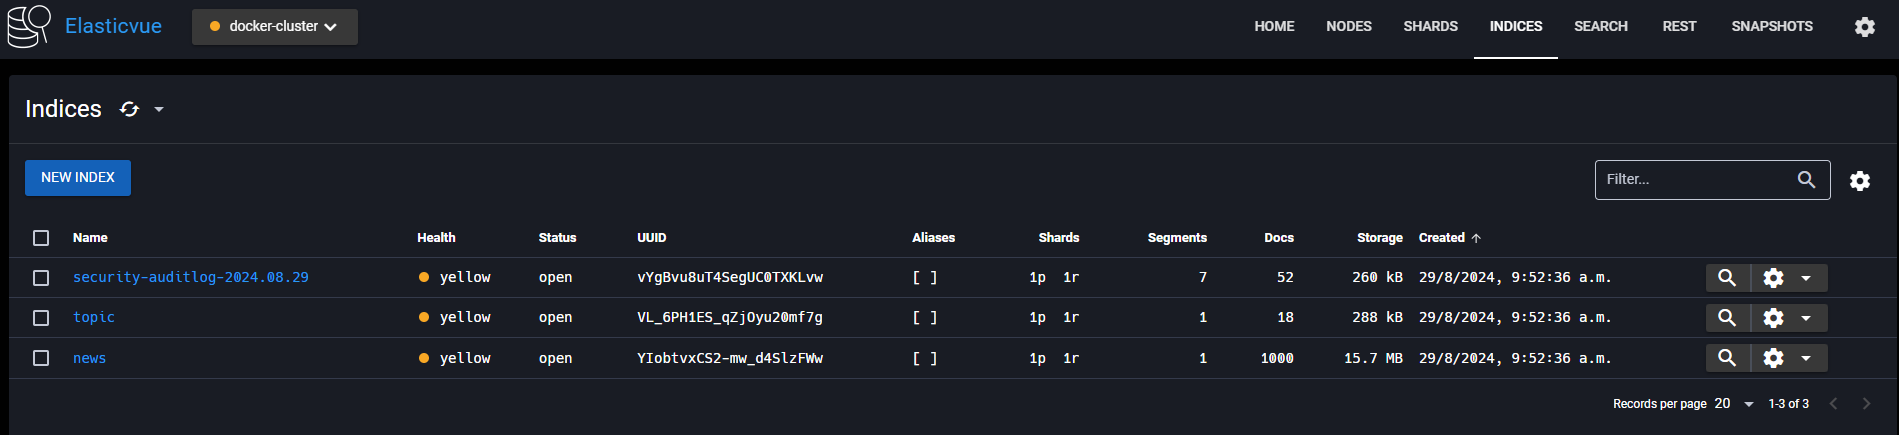

In [46]:
display(Image(filename=r'C:\Users\gabri\OneDrive\Machine Learning\Github\ITBA-NLP\images\elastivue_1.png'))